# U-Net Training and Evaluation

In [1]:
import os # To access system files
from IPython.display import display # Utility to easily display images in this environment
# For image manipulation
import PIL 
from PIL import Image, ImageOps
# Required Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers # To build the U-Net model
from tensorflow.keras.preprocessing.image import load_img # Utility to load images into tensors
# For evaluation metrics
from keras import backend as K
from tensorflow.keras.metrics import MeanIoU
import numpy as np # To transform and manipulate image data
import random # For testing and evaluation
from tensorflow.keras.models import model_from_json # For saving the models to disk

In [2]:
# Importing utils
import Data.DataUtils as DataUtils
from Models.UNet import UNet
from Models.UNetX import UNetX
import Validation.ValidationUtils as Validation

## 1 Data Preprocessing

### 1.1 Loading Image data

In [3]:
input_img_paths, target_img_paths = DataUtils.get_image_paths('./Data/oxford_pets/images/','./Data/oxford_pets/annotations/trimaps/')

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
./Data/oxford_pets/images/Abyssinian_1.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_1.png
./Data/oxford_pets/images/Abyssinian_10.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_10.png
./Data/oxford_pets/images/Abyssinian_100.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_100.png
./Data/oxford_pets/images/Abyssinian_101.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_101.png
./Data/oxford_pets/images/Abyssinian_102.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_102.png
./Data/oxford_pets/images/Abyssinian_103.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_103.png
./Data/oxford_pets/images/Abyssinian_104.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_104.png
./Data/oxford_pets/images/Abyssinian_105.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_105.png
./Data/oxford_pets/images/Abyssinian_106.jpg | ./Data/oxford_pets/annotations/trimaps/Abyssinian_106.png
./Data/oxford_pets/images/Abyssinian_

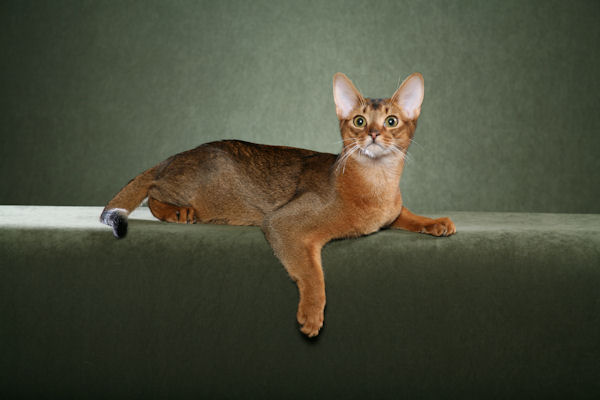

JPEG
(600, 400)
RGB


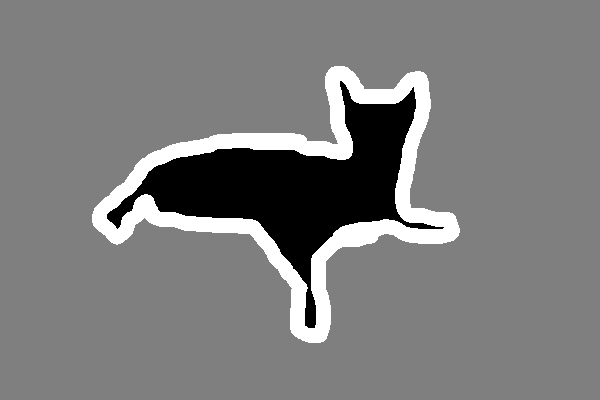

None
(600, 400)
RGB


In [4]:
# Display input image #2
img = PIL.Image.open(input_img_paths[0])
display(img)
print(img.format)
print(img.size)
print(img.mode)

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[0]))
display(img)
print(img.format)
print(img.size)
print(img.mode)

In [5]:
# Finding the minimum image size for training
# * Input images have same dimensions as their masked counterparts
min_width = 9999
min_height = 9999
for input_img_path in input_img_paths:
    img = PIL.Image.open(input_img_path)
    if min_width>img.width:
        min_width = img.width
    if min_height>img.height:
        min_height = img.height
        
print("Minimum width: ", min_width)
print("Minimum height: ", min_height)

Minimum width:  114
Minimum height:  103


### 1.2 Split Data for Training and Validation

In [6]:
def TrainTestSplit(input_img_paths, target_img_paths, split=0.8, r=0):
    random.Random(r).shuffle(input_img_paths)
    random.Random(r).shuffle(target_img_paths)
    train_input_img_paths = input_img_paths[:int(len(input_img_paths)*split)]
    train_target_img_paths = target_img_paths[:int(len(target_img_paths)*split)]
    test_input_img_paths = input_img_paths[-int(len(input_img_paths)*round(1-split,1)):]
    test_target_img_paths = target_img_paths[-int(len(target_img_paths)*round(1-split,1)):]
    return train_input_img_paths, train_target_img_paths, test_input_img_paths, test_target_img_paths

In [7]:
train_input_img_paths, train_target_img_paths, test_input_img_paths, test_target_img_paths = TrainTestSplit(input_img_paths,target_img_paths, split=0.9, r=0)

In [8]:
print(len(train_input_img_paths), len(train_target_img_paths),len(train_input_img_paths)==len(train_target_img_paths))
print(len(test_input_img_paths), len(test_target_img_paths), len(test_input_img_paths)==len(test_target_img_paths))
print(train_input_img_paths[0])
print(train_target_img_paths[0])
print(test_input_img_paths[0])
print(test_target_img_paths[0])

6651 6651 True
739 739 True
./Data/oxford_pets/images/keeshond_32.jpg
./Data/oxford_pets/annotations/trimaps/keeshond_32.png
./Data/oxford_pets/images/havanese_188.jpg
./Data/oxford_pets/annotations/trimaps/havanese_188.png


### 1.3 Preprocess Data

In [15]:
train_data = DataUtils.DataHandler(32, (160, 160), train_input_img_paths, train_target_img_paths)
val_data = DataUtils.DataHandler(32, (160, 160), test_input_img_paths, test_target_img_paths)
print("Tensor shape of image data: ", train_data[0][0].shape)
print("Tensor shape of ground truth: ", train_data[0][1].shape)

Tensor shape of image data:  (32, 160, 160, 3)
Tensor shape of ground truth:  (32, 160, 160, 1)


## 2 Training U-Net Models

### 2.1 Defining Models

In [10]:
IMG_WIDTH = 160
IMG_HEIGHT = 160
IMG_CHANNELS = 3
NUM_CLASSES = 3

Unet_model = UNet(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, NUM_CLASSES).get_model()
UnetX_model = UNetX(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS, NUM_CLASSES).get_model()

In [11]:
Unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

 conv2d_15 (Conv2D)             (None, 80, 80, 32)   9248        ['dropout_7[0][0]']              
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 160, 160, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 160, 160, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 160, 160, 16  4624        ['concatenate_3[0][0]']          
                                )                                                                 
          

In [12]:
UnetX_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 80, 80, 32)   896         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d_19[0][0]']              
 alization)                                                                                       
                                                                                            

                                                                                                  
 conv2d_transpose_4 (Conv2DTran  (None, 10, 10, 256)  590080     ['activation_7[0][0]']           
 spose)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 10, 10, 256)  1024       ['conv2d_transpose_4[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 10, 10, 256)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_transpose_5 (Conv2DTran  (None, 10, 10, 256)  590080     ['activation_8[0][0]']           
 spose)   

                                                                                                  
 conv2d_transpose_11 (Conv2DTra  (None, 80, 80, 32)  9248        ['activation_14[0][0]']          
 nspose)                                                                                          
                                                                                                  
 batch_normalization_14 (BatchN  (None, 80, 80, 32)  128         ['conv2d_transpose_11[0][0]']    
 ormalization)                                                                                    
                                                                                                  
 up_sampling2d_7 (UpSampling2D)  (None, 160, 160, 64  0          ['add_5[0][0]']                  
                                )                                                                 
                                                                                                  
 up_sampli

### 2.2 Training Models

Test if GPU is available before training

In [11]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### 2.2.1 Train U-Net Model

In [14]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
Unet_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Checkpoints/unet_segmentation.h5", save_best_only=True, verbose=1),
    #f.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'), #results in 26 epochs on average
    tf.keras.callbacks.TensorBoard(log_dir='Logs/unet_scrap/') #scrap stands for any training that is not meant to be recorded in detail
]

# Train the model, doing validation at the end of each epoch.
#epochs = 100
epochs = 15
Unet_model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=callbacks)

Epoch 1/100
207/207 [==============================] - ETA: 0s - loss: 0.8729
Epoch 1: val_loss improved from inf to 0.70401, saving model to Checkpoints\unet_segmentation.h5
207/207 [==============================] - 44s 181ms/step - loss: 0.8729 - val_loss: 0.7040
Epoch 2/100
207/207 [==============================] - ETA: 0s - loss: 0.6577
Epoch 2: val_loss improved from 0.70401 to 0.59146, saving model to Checkpoints\unet_segmentation.h5
207/207 [==============================] - 37s 179ms/step - loss: 0.6577 - val_loss: 0.5915
Epoch 3/100
207/207 [==============================] - ETA: 0s - loss: 0.5513
Epoch 3: val_loss improved from 0.59146 to 0.48506, saving model to Checkpoints\unet_segmentation.h5
207/207 [==============================] - 36s 172ms/step - loss: 0.5513 - val_loss: 0.4851
Epoch 4/100
207/207 [==============================] - ETA: 0s - loss: 0.4982
Epoch 4: val_loss improved from 0.48506 to 0.45120, saving model to Checkpoints\unet_segmentation.h5
207/207 [===

207/207 [==============================] - 37s 179ms/step - loss: 0.2080 - val_loss: 0.3547
Epoch 36/100
207/207 [==============================] - ETA: 0s - loss: 0.2072
Epoch 36: val_loss did not improve from 0.32239
207/207 [==============================] - 37s 178ms/step - loss: 0.2072 - val_loss: 0.3376
Epoch 37/100
207/207 [==============================] - ETA: 0s - loss: 0.2032
Epoch 37: val_loss did not improve from 0.32239
207/207 [==============================] - 36s 175ms/step - loss: 0.2032 - val_loss: 0.3459
Epoch 38/100
207/207 [==============================] - ETA: 0s - loss: 0.2013
Epoch 38: val_loss did not improve from 0.32239
207/207 [==============================] - 36s 172ms/step - loss: 0.2013 - val_loss: 0.4266
Epoch 39/100
207/207 [==============================] - ETA: 0s - loss: 0.1972
Epoch 39: val_loss did not improve from 0.32239
207/207 [==============================] - 36s 172ms/step - loss: 0.1972 - val_loss: 0.3402
Epoch 40/100
207/207 [==========

Epoch 73/100
207/207 [==============================] - ETA: 0s - loss: 0.1636
Epoch 73: val_loss did not improve from 0.32239
207/207 [==============================] - 35s 171ms/step - loss: 0.1636 - val_loss: 0.3943
Epoch 74/100
207/207 [==============================] - ETA: 0s - loss: 0.1614
Epoch 74: val_loss did not improve from 0.32239
207/207 [==============================] - 38s 185ms/step - loss: 0.1614 - val_loss: 0.3823
Epoch 75/100
207/207 [==============================] - ETA: 0s - loss: 0.1605
Epoch 75: val_loss did not improve from 0.32239
207/207 [==============================] - 35s 169ms/step - loss: 0.1605 - val_loss: 0.3825
Epoch 76/100
207/207 [==============================] - ETA: 0s - loss: 0.1600
Epoch 76: val_loss did not improve from 0.32239
207/207 [==============================] - 36s 175ms/step - loss: 0.1600 - val_loss: 0.3687
Epoch 77/100
207/207 [==============================] - ETA: 0s - loss: 0.1594
Epoch 77: val_loss did not improve from 0.322

#### Optional: Save model to JSON

In [16]:
# serialize model to JSON
Unet_json = Unet_model.to_json()
with open("Models/Unet_scrap.json", "w") as json_file:
    json_file.write(Unet_json)
# serialize weights to HDF5
Unet_model.save_weights("Models/Unet_scrap.h5")
print("Saved model to disk")

Saved model to disk


#### 2.2.1 Train U-Net XceptionModel

In [12]:
UnetX_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Checkpoints/unetx_segmentation.h5", save_best_only=True, verbose=1),
    #tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'), # on average it caps at 12 epochs
    tf.keras.callbacks.TensorBoard(log_dir='Logs/unetx_scrap/')
]

# Train the model, doing validation at the end of each epoch.
#epochs = 100
epochs = 15
UnetX_model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=callbacks)

Epoch 1/15
207/207 [==============================] - ETA: 0s - loss: 0.8977
Epoch 1: val_loss improved from inf to 1.84858, saving model to Checkpoints\unetx_segmentation.h5
207/207 [==============================] - 58s 251ms/step - loss: 0.8977 - val_loss: 1.8486
Epoch 2/15
207/207 [==============================] - ETA: 0s - loss: 0.4982
Epoch 2: val_loss did not improve from 1.84858
207/207 [==============================] - 51s 247ms/step - loss: 0.4982 - val_loss: 2.1796
Epoch 3/15
207/207 [==============================] - ETA: 0s - loss: 0.4251
Epoch 3: val_loss improved from 1.84858 to 0.41562, saving model to Checkpoints\unetx_segmentation.h5
207/207 [==============================] - 54s 261ms/step - loss: 0.4251 - val_loss: 0.4156
Epoch 4/15
207/207 [==============================] - ETA: 0s - loss: 0.3780
Epoch 4: val_loss did not improve from 0.41562
207/207 [==============================] - 54s 258ms/step - loss: 0.3780 - val_loss: 0.4337
Epoch 5/15
207/207 [==========

In [13]:
# serialize model to JSON
UnetX_json = UnetX_model.to_json()
with open("Models/UnetX_scrap.json", "w") as json_file:
    json_file.write(UnetX_json)
# serialize weights to HDF5
UnetX_model.save_weights("Models/UnetX_scrap.h5")
print("Saved model to disk")

Saved model to disk


## 3. Model Evaluation

### Helper functions

In [58]:
def display_mask(i, val_preds):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

In [22]:
""" Helper function to compute IoU scores for one result """
def IoU(GROUND_TRUTH, ACTUAL, BATCH_SIZE, IMG_SIZE):
    # get predicted mask
    mask = np.argmax(ACTUAL, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    
    # get the ground truth mask into array
    ground_truth = np.zeros((BATCH_SIZE,) + IMG_SIZE + (1,), dtype="uint8")
    truth_mask = load_img(GROUND_TRUTH, target_size=IMG_SIZE, color_mode="grayscale")
    ground_truth = np.expand_dims(truth_mask, 2)
    ground_truth -=1
    
    # compute mean Intersection-Over-Union
    IOU_Keras = MeanIoU(num_classes=3) # Hardcoded for this problem: 3 classes
    IOU_Keras.update_state(ground_truth,mask)
    print("Mean IoU = ", "%.4f" % IOU_Keras.result().numpy())
    
    # print IoU per class (except background)
    values = np.array(IOU_Keras.get_weights()).reshape(3, 3)
    class1_IoU = values[1,1]/(values[1,1] + values[1,2] + values[2,1])
    class2_IoU = values[2,2]/(values[2,2] + values[2,1] + values[1,2])
    print("Class 1 IoU = ", "%.4f" % class1_IoU)
    print("Class 2 IoU = ", "%.4f" % class2_IoU)
    

In [23]:
""" Helper function to compute IoU scores for all results """
def Total_IoU(GROUND_TRUTHS, PREDICTIONS, BATCH_SIZE, IMG_SIZE):
    mean_IoU = []
    average_class1 = []
    average_class2 = []
    
    for i in range(len(PREDICTIONS)):
        # get predicted mask
        mask = np.argmax(PREDICTIONS[i], axis=-1)
        mask = np.expand_dims(mask, axis=-1)

        # get the ground truth mask into array
        ground_truth = np.zeros((BATCH_SIZE,) + IMG_SIZE + (1,), dtype="uint8")
        truth_mask = load_img(GROUND_TRUTHS[i], target_size=IMG_SIZE, color_mode="grayscale")
        ground_truth = np.expand_dims(truth_mask, 2)
        ground_truth -=1

        # compute mean Intersection-Over-Union
        IOU_Keras = MeanIoU(num_classes=3) # Hardcoded for this problem: 3 classes
        IOU_Keras.update_state(ground_truth,mask)
        mean_IoU.append(IOU_Keras.result().numpy())

        # print IoU per class (except background)
        values = np.array(IOU_Keras.get_weights()).reshape(3, 3)
        class1_IoU = values[1,1]/(values[1,1] + values[1,2] + values[2,1])
        class2_IoU = values[2,2]/(values[2,2] + values[2,1] + values[1,2])
        average_class1.append(class1_IoU)
        average_class2.append(class2_IoU)
        
    print("Overall Mean IoU = ", "%.4f" % (sum(mean_IoU)/len(mean_IoU)*100), "%")
    print("Average Class 1 IoU = ", "%.4f" % (sum(average_class1)/len(average_class1)*100), "%")
    print("Average Class 2 IoU = ", "%.4f" % (sum(average_class2)/len(average_class2)*100), "%")


In [24]:
""" Helper function to compute IoU scores for all results """
def Dice_Coef(GROUND_TRUTH, ACTUAL, BATCH_SIZE, IMG_SIZE):
    
    # get predicted mask
    mask = np.argmax(ACTUAL, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    # get the ground truth mask into array
    ground_truth = np.zeros((BATCH_SIZE,) + IMG_SIZE + (1,), dtype="uint8")
    truth_mask = load_img(GROUND_TRUTH, target_size=IMG_SIZE, color_mode="grayscale")
    ground_truth = np.expand_dims(truth_mask, 2)
    ground_truth -=1
    
    y_true_f = ground_truth.flatten()
    y_pred_f = mask.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    print("Dice Coeficient = ", "%.4f" % (intersection / union*100), "%")

## 3.1 Unet

In [49]:
# Optional:
# load json and create model
json_file = open('Models/Unet_auto.json', 'r')
loaded_Unet_json = json_file.read()
json_file.close()
loaded_Unet = model_from_json(loaded_Unet_json)
# load weights into new model
loaded_Unet.load_weights("Models/Unet_auto.h5")
print("Loaded model from disk")

Loaded model from disk


In [50]:
#val_preds = Unet_model.predict(val_data)
val_preds = loaded_Unet.predict(val_data)

23/23 [==============================] - 2s 66ms/step


In [51]:
BATCH_SIZE=32
IMG_SIZE = (160,160)
NUM_CLASSES = 3
GROUND_TRUTH = test_target_img_paths[13]
ACTUAL = val_preds[13]

GROUND_TRUTHS = test_target_img_paths
PREDICTIONS = val_preds

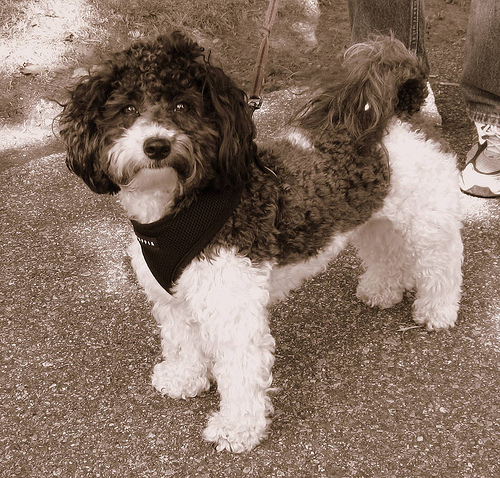

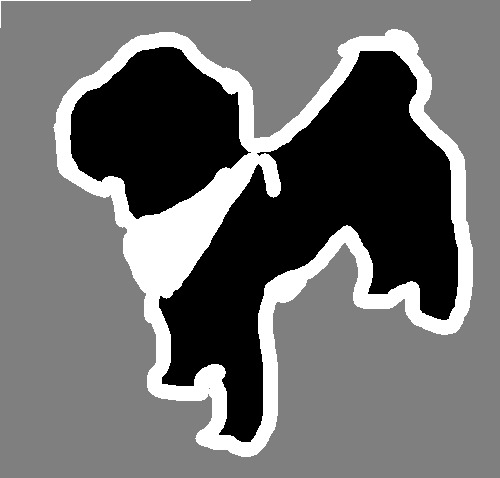

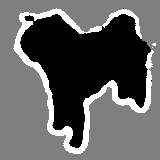

In [52]:
# Display input image
display(Image.open(test_input_img_paths[0]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(test_target_img_paths[0]))
display(img)

# Display mask predicted by our model
display_mask(0, val_preds)  # Inputs was resized at 160x160.

### Intersection over Union

In [53]:
IoU(GROUND_TRUTH=test_target_img_paths[0], ACTUAL=val_preds[0], BATCH_SIZE=32, IMG_SIZE=(160,160))
Total_IoU(GROUND_TRUTHS=test_target_img_paths, PREDICTIONS=val_preds, BATCH_SIZE=32, IMG_SIZE=(160,160))
Dice_Coef(GROUND_TRUTH=test_target_img_paths[0], ACTUAL=val_preds[0], BATCH_SIZE=32, IMG_SIZE=(160,160))

Mean IoU =  0.6914
Class 1 IoU =  0.9287
Class 2 IoU =  0.6451
Overall Mean IoU =  71.3478 %
Average Class 1 IoU =  92.0617 %
Average Class 2 IoU =  63.9601 %
Dice Coeficient =  55.4952 %


## 3.2 UnetX

In [65]:
# Optional:
# load json and create model
json_file = open('Models/UnetX_auto.json', 'r')
loaded_Unet_json = json_file.read()
json_file.close()
loaded_UnetX = model_from_json(loaded_Unet_json)
# load weights into new model
loaded_UnetX.load_weights("Models/UnetX_auto.h5")
print("Loaded model from disk")

Loaded model from disk


In [66]:
#val_preds = UnetX_model.predict(val_data)
val_preds = loaded_UnetX.predict(val_data)

23/23 [==============================] - 2s 68ms/step


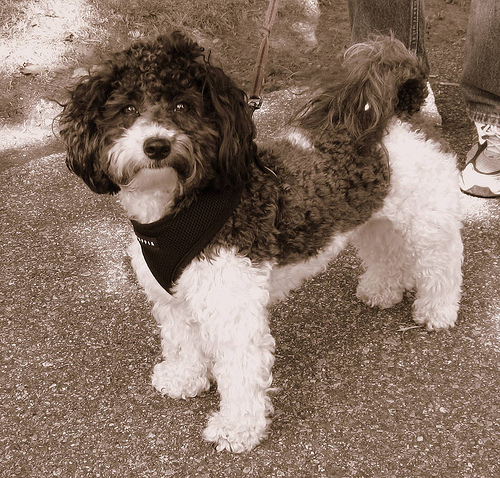

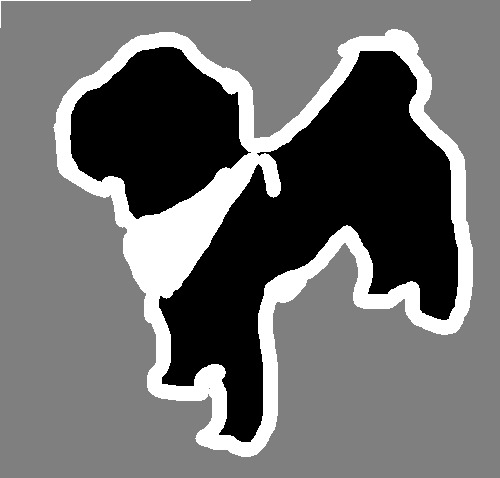

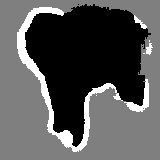

In [67]:
# Display input image
display(Image.open(test_input_img_paths[0]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(test_target_img_paths[0]))
display(img)

# Display mask predicted by our model
display_mask(0, val_preds)  # Inputs was resized at 160x160.

### Intersection over Union

In [68]:
IoU(GROUND_TRUTH=test_target_img_paths[0], ACTUAL=val_preds[0], BATCH_SIZE=32, IMG_SIZE=(160,160))
Total_IoU(GROUND_TRUTHS=test_target_img_paths, PREDICTIONS=val_preds, BATCH_SIZE=32, IMG_SIZE=(160,160))
Dice_Coef(GROUND_TRUTH=test_target_img_paths[0], ACTUAL=val_preds[0], BATCH_SIZE=32, IMG_SIZE=(160,160))

Mean IoU =  0.5864
Class 1 IoU =  0.9200
Class 2 IoU =  0.5348
Overall Mean IoU =  64.5776 %
Average Class 1 IoU =  90.2929 %
Average Class 2 IoU =  52.3362 %
Dice Coeficient =  50.2303 %
